In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
column_names = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 27)]
train_df = pd.read_csv('../dataset/train_FD001.txt', sep='\s+', header=None, names=column_names)
test_df = pd.read_csv('../dataset/test_FD001.txt', sep='\s+', header=None, names=column_names)
true_rul = pd.read_csv('../dataset/RUL_FD001.txt', header=None)
# Dropping Columns
columns_to_drop = ["setting1", "setting2", "setting3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19", "sensor22", "sensor23", "sensor24", "sensor25", "sensor26"]
train_df_dropped = train_df.drop(columns=columns_to_drop)
test_df_dropped = test_df.drop(columns=columns_to_drop)
train_df = train_df_dropped.dropna(axis=1, how="all")
test_df = test_df_dropped.dropna(axis=1, how="all")

# RNG
rng = np.random.RandomState(42)

In [99]:
train_df.head()

,engine_id,cycle,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


In [100]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Separate the columns to normalize and the columns to skip
columns_to_skip = train_df.columns[:2]
columns_to_normalize = train_df.columns[2:]

# Normalize only the selected columns
normalized_data = scaler.fit_transform(train_df[columns_to_normalize])

# Combine the normalized and unnormalized columns
train_df_normalized = pd.DataFrame(train_df[columns_to_skip].values, columns=columns_to_skip)
train_df_normalized = pd.concat([train_df_normalized, pd.DataFrame(normalized_data, columns=columns_to_normalize)], axis=1)

test_normalized = scaler.transform(test_df[columns_to_normalize])
test_df_normalized = pd.DataFrame(train_df[columns_to_skip].values, columns=columns_to_skip)
test_df_normalized = pd.concat([test_df[columns_to_skip].reset_index(drop=True),
                                pd.DataFrame(test_normalized, columns=columns_to_normalize)], axis=1)


In [101]:
train_df_normalized['RUL'] = train_df_normalized.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)

In [102]:
train_df_normalized.head()

,engine_id,cycle,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,RUL
0,1,1,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191
1,1,2,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190
2,1,3,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189
3,1,4,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188
4,1,5,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187


In [103]:
sensor_list = list(train_df_normalized.columns[2:16])

In [104]:
feature_dfs = []
label_list = []

# Define the window size (e.g., last 30 cycles)
window_size = 30

for engine_id in train_df_normalized['engine_id'].unique():
    engine_data = train_df_normalized[train_df_normalized['engine_id'] == engine_id]
    max_cycle = engine_data['cycle'].max()
    for i in range(window_size, max_cycle + 1):
        window_data = engine_data[(engine_data['cycle'] >= i - window_size) & (engine_data['cycle'] <= i)]
        # Assign unique IDs for tsfresh
        window_data = window_data.copy()
        window_data['id'] = f'{engine_id}_{i}'
        
        # Corrected line: Convert Index to list before concatenation
        columns_to_select = ['id', 'cycle'] + sensor_list
        
        # Append to the list using the corrected columns
        feature_dfs.append(window_data[columns_to_select])
        
        # Get the RUL at this point
        rul = engine_data[engine_data['cycle'] == i]['RUL'].values[0]
        label_list.append({'id': f'{engine_id}_{i}', 'RUL': rul})


In [105]:
tsfresh_input_df = pd.concat(feature_dfs)
tsfresh_input_df.shape

(549561, 16)

In [106]:
# Create the label dataframe
labels_df = pd.DataFrame(label_list)

In [107]:
labels_df.head(3)

,id,RUL
0,1_30,162
1,1_31,161
2,1_32,160


In [108]:
labels_df[labels_df["id"] == '100_100']

,id,RUL
17630,100_100,100


In [109]:
labels_df.shape

(17731, 2)

In [110]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction import MinimalFCParameters
extraction_settings = MinimalFCParameters()
# Set up parameters for feature extraction
# extraction_settings = EfficientFCParameters()


In [111]:
extracted_features = extract_features(
    tsfresh_input_df,
    column_id='id',
    column_sort='cycle',
    default_fc_parameters=extraction_settings,
    n_jobs=4
)

Feature Extraction: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


In [112]:
extracted_features.shape

(17731, 140)

In [113]:
extracted_features.head(3)

,sensor2__sum_values,sensor2__median,sensor2__mean,sensor2__length,sensor2__standard_deviation,sensor2__variance,sensor2__root_mean_square,sensor2__maximum,sensor2__absolute_maximum,sensor2__minimum,...,sensor21__sum_values,sensor21__median,sensor21__mean,sensor21__length,sensor21__standard_deviation,sensor21__variance,sensor21__root_mean_square,sensor21__maximum,sensor21__absolute_maximum,sensor21__minimum
100_100,12.590361,0.403614,0.406141,31.0,0.095188,0.009061,0.417146,0.60241,0.60241,0.177711,...,17.632974,0.584507,0.568806,31.0,0.080112,0.006418,0.574419,0.683237,0.683237,0.378349
100_101,12.647590,0.403614,0.407987,31.0,0.092423,0.008542,0.418324,0.60241,0.60241,0.177711,...,17.654791,0.588097,0.569509,31.0,0.080234,0.006438,0.575133,0.683237,0.683237,0.378349
100_102,12.777108,0.427711,0.412165,31.0,0.092743,0.008601,0.422470,0.60241,0.60241,0.177711,...,17.489229,0.588097,0.564169,31.0,0.085654,0.007337,0.570634,0.683237,0.683237,0.378349


In [114]:
extracted_features.loc['100_100']

sensor2__sum_values            12.590361
sensor2__median                 0.403614
sensor2__mean                   0.406141
sensor2__length                31.000000
sensor2__standard_deviation     0.095188
                                 ...    
sensor21__variance              0.006418
sensor21__root_mean_square      0.574419
sensor21__maximum               0.683237
sensor21__absolute_maximum      0.683237
sensor21__minimum               0.378349
Name: 100_100, Length: 140, dtype: float64

In [115]:
# Merge labels back to extracted features by window_id
features_labels_df = extracted_features.merge(labels_df, left_index=True, right_on='id')

In [116]:
features_labels_df.head(10)

,sensor2__sum_values,sensor2__median,sensor2__mean,sensor2__length,sensor2__standard_deviation,sensor2__variance,sensor2__root_mean_square,sensor2__maximum,sensor2__absolute_maximum,sensor2__minimum,...,sensor21__mean,sensor21__length,sensor21__standard_deviation,sensor21__variance,sensor21__root_mean_square,sensor21__maximum,sensor21__absolute_maximum,sensor21__minimum,id,RUL
17630,12.590361,0.403614,0.406141,31.0,0.095188,0.009061,0.417146,0.60241,0.60241,0.177711,...,0.568806,31.0,0.080112,0.006418,0.574419,0.683237,0.683237,0.378349,100_100,100
17631,12.647590,0.403614,0.407987,31.0,0.092423,0.008542,0.418324,0.60241,0.60241,0.177711,...,0.569509,31.0,0.080234,0.006438,0.575133,0.683237,0.683237,0.378349,100_101,99
17632,12.777108,0.427711,0.412165,31.0,0.092743,0.008601,0.422470,0.60241,0.60241,0.177711,...,0.564169,31.0,0.085654,0.007337,0.570634,0.683237,0.683237,0.378349,100_102,98
17633,12.861446,0.430723,0.414885,31.0,0.092541,0.008564,0.425081,0.60241,0.60241,0.177711,...,0.557331,31.0,0.091716,0.008412,0.564827,0.683237,0.683237,0.376139,100_103,97
17634,12.816265,0.430723,0.413428,31.0,0.093766,0.008792,0.423928,0.60241,0.60241,0.177711,...,0.558690,31.0,0.090662,0.008220,0.565998,0.683237,0.683237,0.376139,100_104,96
17635,12.912651,0.430723,0.416537,31.0,0.091361,0.008347,0.426439,0.60241,0.60241,0.177711,...,0.557100,31.0,0.089680,0.008042,0.564272,0.683237,0.683237,0.376139,100_105,95
17636,12.825301,0.427711,0.413719,31.0,0.091669,0.008403,0.423753,0.60241,0.60241,0.177711,...,0.555853,31.0,0.089360,0.007985,0.562990,0.683237,0.683237,0.376139,100_106,94
17637,12.710843,0.427711,0.410027,31.0,0.094269,0.008887,0.420724,0.60241,0.60241,0.177711,...,0.550400,31.0,0.087261,0.007614,0.557275,0.683237,0.683237,0.376139,100_107,93
17638,12.539157,0.400602,0.404489,31.0,0.097181,0.009444,0.415999,0.60241,0.60241,0.177711,...,0.557692,31.0,0.092177,0.008497,0.565259,0.727561,0.727561,0.376139,100_108,92
17639,12.515060,0.400602,0.403712,31.0,0.097858,0.009576,0.415402,0.60241,0.60241,0.177711,...,0.562610,31.0,0.094321,0.008896,0.570461,0.727561,0.727561,0.376139,100_109,91


In [117]:
# Drop 'id' and 'RUL' columns to get the feature matrix
X = features_labels_df.drop(['id', 'RUL'], axis=1)

# Target vector
y = features_labels_df['RUL']

In [118]:
from tsfresh import select_features

In [119]:
X_selected = select_features(X, y)

In [120]:
X_selected.shape # seems like all is chosen??

(17731, 140)

In [121]:
# Extract engine IDs from 'id'
features_labels_df['engine_id'] = features_labels_df['id'].apply(lambda x: x.split('_')[0])

# Get unique engine IDs
engine_ids = features_labels_df['engine_id'].unique()

# Split engine IDs into training and testing sets
train_engine_ids, test_engine_ids = train_test_split(engine_ids, test_size=0.2, random_state=42)

# Create masks for training and testing data
train_mask = features_labels_df['engine_id'].isin(train_engine_ids)
test_mask = features_labels_df['engine_id'].isin(test_engine_ids)

# Split the data based on engine
X_train = X_selected[train_mask]
X_test = X_selected[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

## Linear Regression

In [122]:
# Initialize and train your model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [123]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

35.46071433101609

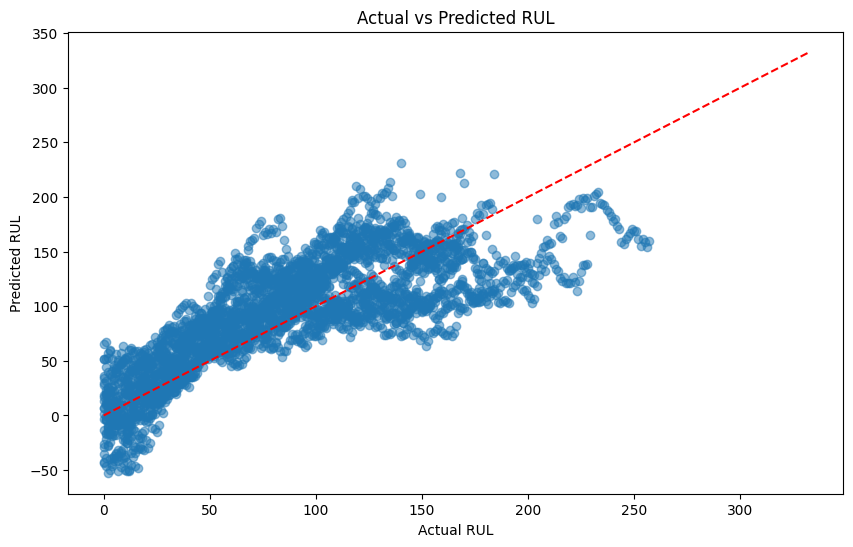

In [124]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()

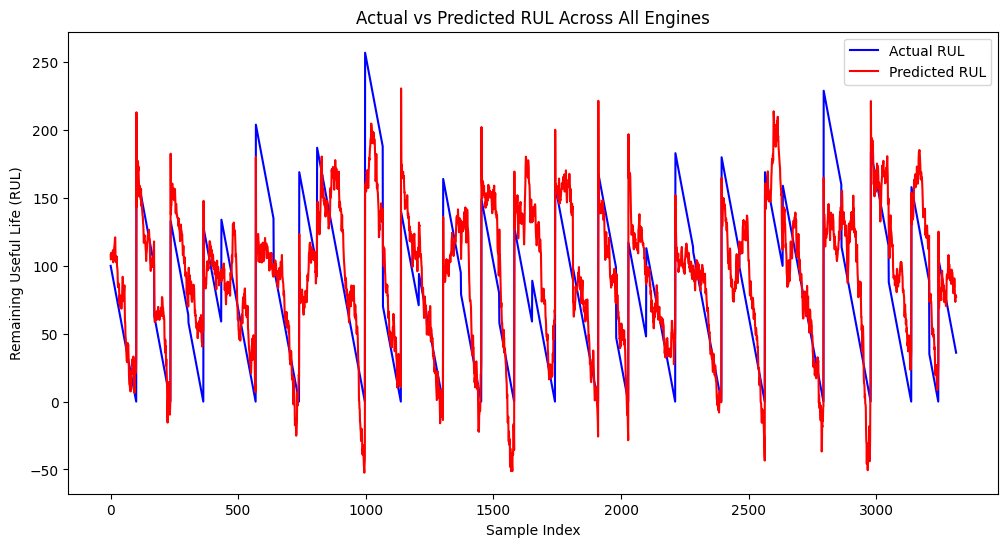

In [125]:
results_df = pd.DataFrame({
    'Actual RUL': y_test,
    'Predicted RUL': y_pred
})
# Reset the index to ensure sequential ordering
results_df = results_df.reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual RUL'], label='Actual RUL', color='blue')
plt.plot(results_df['Predicted RUL'], label='Predicted RUL', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('Actual vs Predicted RUL Across All Engines')
plt.legend()
plt.show()

## Random Forest Regressor

In [126]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [127]:
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

32.80376819996567

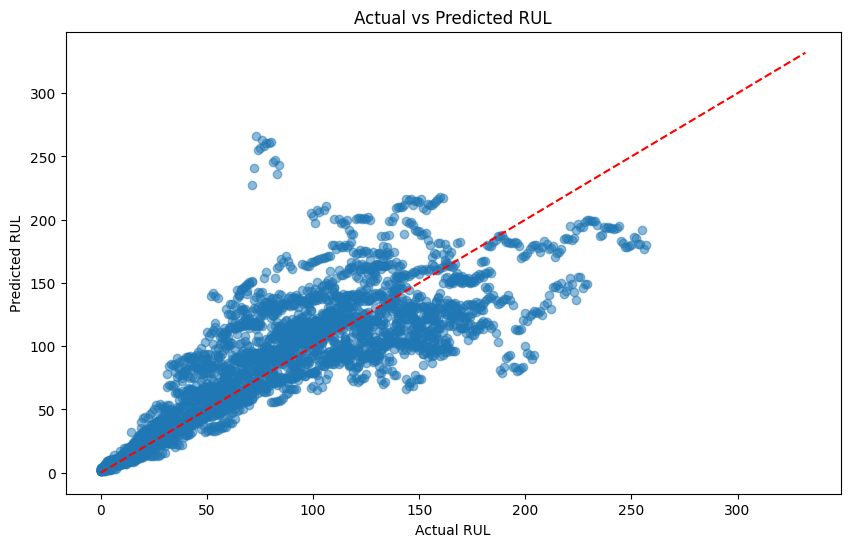

In [128]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()

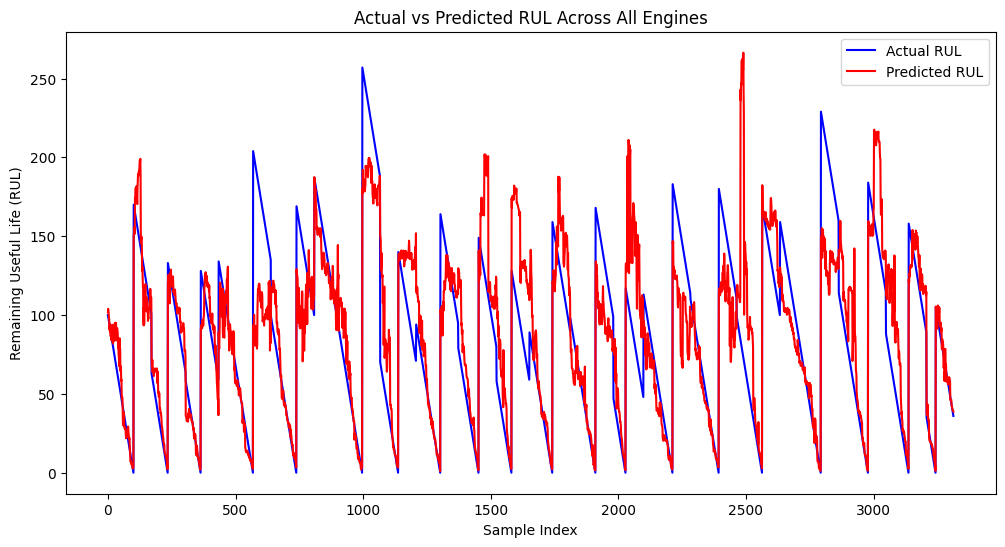

In [129]:
import matplotlib.pyplot as plt

results_df = pd.DataFrame({
    'Actual RUL': y_test,
    'Predicted RUL': y_pred
})
# Reset the index to ensure sequential ordering
results_df = results_df.reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual RUL'], label='Actual RUL', color='blue')
plt.plot(results_df['Predicted RUL'], label='Predicted RUL', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('Actual vs Predicted RUL Across All Engines')
plt.legend()
plt.show()

## Gradient Boosting Regressor

In [130]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

32.74633861254996

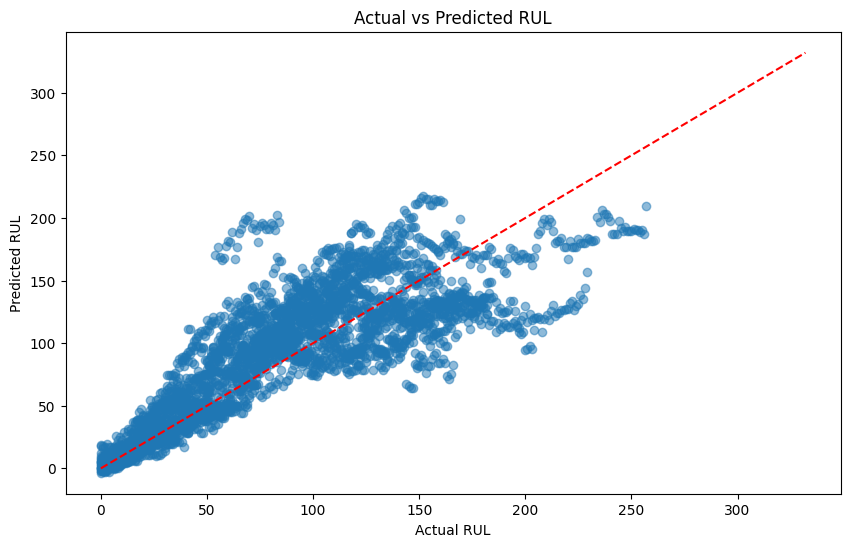

In [131]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()

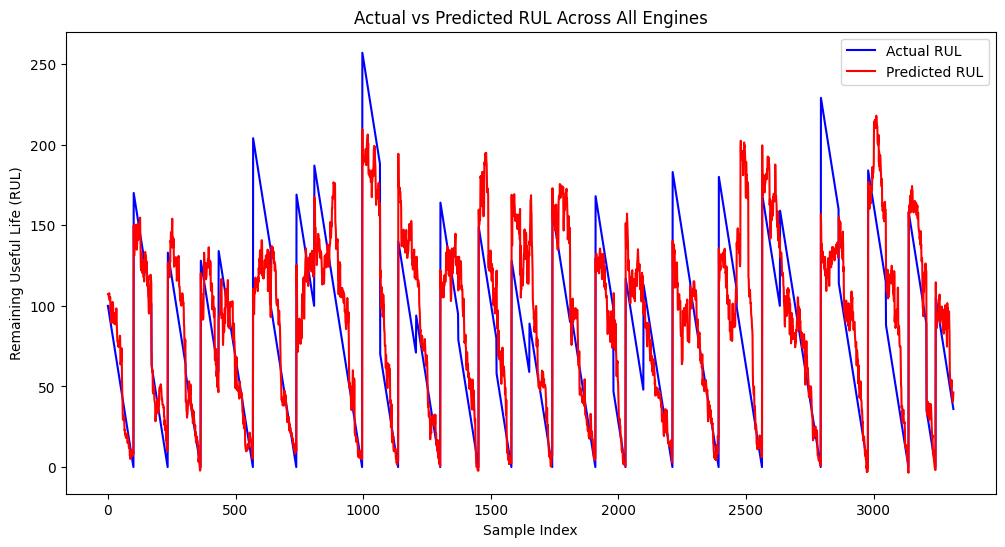

In [132]:
results_df = pd.DataFrame({
    'Actual RUL': y_test,
    'Predicted RUL': y_pred
})
# Reset the index to ensure sequential ordering
results_df = results_df.reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual RUL'], label='Actual RUL', color='blue')
plt.plot(results_df['Predicted RUL'], label='Predicted RUL', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('Actual vs Predicted RUL Across All Engines')
plt.legend()
plt.show()